#                                    **NETFLIX MOVIE RECOMMENDATION SYSTEM**    

By D Yakshitha(1RN18IS035)

# 1. Business Problem

1.1 Problem Description:
Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better.

Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.


1.2 Problem Statement:

Netflix provided a lot of rating data from which a recommendation system is built. Given different details about users and movies problem is to predict movies that would be best rated by a user


1.3 Sources : Data: https://www.kaggle.com/walidbenchikha/netflix-recommendation/data surprise library: http://surpriselib.com/ surprise library doc: http://surprise.readthedocs.io/en/stable/getting_started.html (we use many models from this library) installing surprise: https://github.com/NicolasHug/Surprise#installation Research paper: http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf (most of our work was inspired by this paper) Best Algorithm(SVD):https://github.com/nishantml/NETFLIX-MOVIE-RECOMMENDATION-SYSTEM/blob/master/Netflix_Movie.ipynb


1.4 Real world/Business Objectives and constraints:

Objectives:

Predict the rating that a user would give to a movie that he has not yet rated. Minimize the difference between predicted and actual rating (RMSE and MAPE)

Constraints:

Some form of interpretability.


# 2. Machine Learning Problem

2.1 Data 
2.1.1 Data Overview Get the data from :  https://www.kaggle.com/rounakbanik/the-movies-dataset
Data files : credits.csv keywords.csv links.csv links_small.csv movies_metadata.csv ratings.csv ratings_small.csv

*credits file contains cast and crew details of every movie. *keywords file contains Cast and Crew Information for all movies in the movies_metadata.csv file. *links file contains IMDB and TMDB IDs of all movies featured in the ratings.csv file (About 45,000 movies). *links_small file contains IMDB and TMDB IDs of all movies featured in the ratings_small.csv file (About 9000 movies). *movies_metadata has 24 columns representing information about every movie like genres,id,production company,voting,run time,budget and so on. *ratings file contains ratings given by users to movies. *ratings_small file contains 100 ratings from 700 users on 9,000 +91 88708 42439. Is a subset of the ratings available in the Full MovieLens dataset.


2.2 Mapping the real world problem to a Machine Learning Problem:

2.2.1 Type of Machine Learning Problem For a given movie and user we need to predict the similar movies for which highest ratings would be given by him/her to the movie. The given problem is a Recommendation problem It can also seen as a Regression problem

2.2.2 Performance metric Mean Absolute Percentage Error: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error Root Mean Square Error: https://en.wikipedia.org/wiki/Root-mean-square_deviation

2.2.3 Machine Learning Objective and Constraints Minimize RMSE. Try to provide some interpretability.

# 3. Exploratory Data Analysis

# 3.1 Preprocessing

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd

In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [3]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [4]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

Reading credits.csv file

In [5]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# credits.csv has 45476 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('C:\\Users\\YAKSHITHA DONTHI\\Downloads\\archive\\credits.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'credits.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 3 columns


In [6]:
df1.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [7]:
plotPerColumnDistribution(df1, 10, 5)

<Figure size 2400x512 with 0 Axes>

Reading keywords.csv file

In [9]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# keywords.csv has 46419 rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('C:\\Users\\YAKSHITHA DONTHI\\Downloads\\archive\\keywords.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'keywords.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 2 columns


In [10]:
df2.head(5)


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [11]:
plotPerColumnDistribution(df2, 10, 5)

<Figure size 2400x512 with 0 Axes>

In [ ]:
Reading links.csv file

In [12]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# links_small.csv has 9125 rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('C:\\Users\\YAKSHITHA DONTHI\\Downloads\\archive\\links_small.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'links_small.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 3 columns


In [13]:
df3.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [14]:
plotPerColumnDistribution(df3, 10, 5)

<Figure size 2400x512 with 0 Axes>

Plotting heatmap between movieid and imdbid values

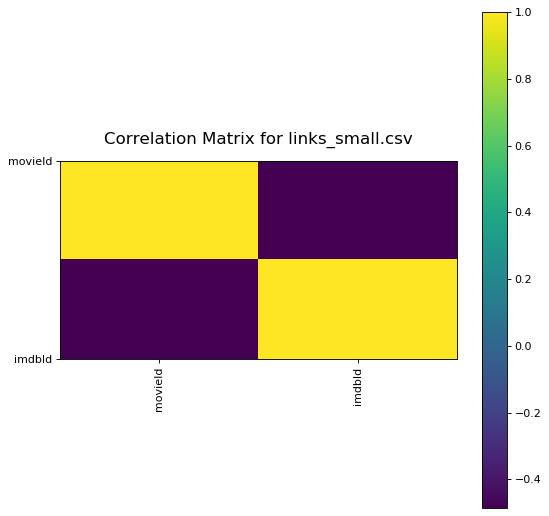

In [16]:
plotCorrelationMatrix(df3, 8)

conclusion: movie id and imbdb id are not correlated

Scatter and density plots for movie and imdb id

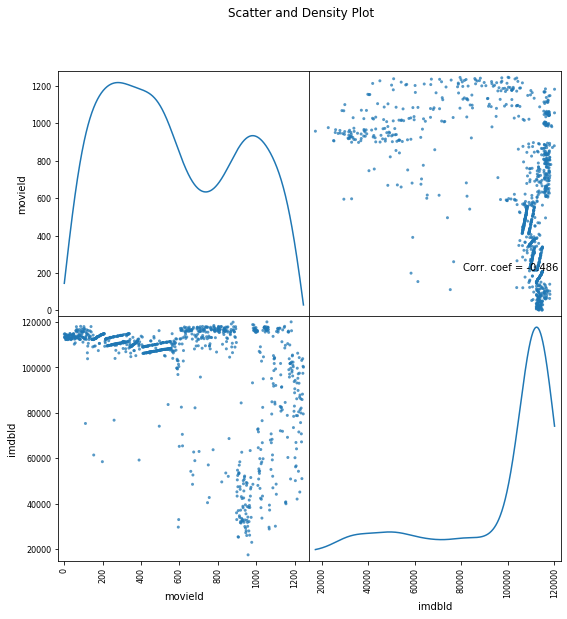

In [17]:
plotScatterMatrix(df3, 9, 10)

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import warnings; warnings.simplefilter('ignore')

Reading movies_metadata.csv file

In [21]:
md = pd. read_csv('C:\\Users\\YAKSHITHA DONTHI\\Downloads\\archive\\movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [22]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [23]:
C = md['vote_average'].mean()
m= md['vote_count'].quantile(0.95)
print("C is %f, and m is %d"%(C,m))

C is 5.618207, and m is 434


In [24]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())]
qualified.shape

(2274, 25)

In [25]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)
qualified = qualified[['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['score'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('score', ascending=False)
qualified.head(10)

,title,year,vote_count,vote_average,popularity,genres,score
314,The Shawshank Redemption,1994,8358.0,8.5,51.6454,"[Drama, Crime]",8.357746
834,The Godfather,1972,6024.0,8.5,41.1093,"[Drama, Crime]",8.306334
12481,The Dark Knight,2008,12269.0,8.3,123.167,"[Drama, Action, Crime, Thriller]",8.208376
2843,Fight Club,1999,9678.0,8.3,63.8696,[Drama],8.184899
292,Pulp Fiction,1994,8670.0,8.3,140.95,"[Thriller, Crime]",8.172155
351,Forrest Gump,1994,8147.0,8.2,48.3072,"[Comedy, Drama, Romance]",8.069421
522,Schindler's List,1993,4436.0,8.3,41.7251,"[Drama, History, War]",8.061007
23673,Whiplash,2014,4376.0,8.3,64.3,[Drama],8.058025
5481,Spirited Away,2001,3968.0,8.3,41.0489,"[Fantasy, Adventure, Animation, Family]",8.035598
1154,The Empire Strikes Back,1980,5998.0,8.2,19.471,"[Adventure, Action, Science Fiction]",8.025793


Checking for rows containing NaN values

In [27]:
links = pd.read_csv('C:\\Users\\YAKSHITHA DONTHI\\Downloads\\archive\\links_small.csv')
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')
print (md[pd.to_numeric(md['id'], errors='coerce').isnull()])

                                                   adult  \
19730                                 - Written by Ørnås   
29503   Rune Balot goes to a casino connected to the ...   
35587   Avalanche Sharks tells the story of a bikini ...   

      belongs_to_collection                            budget  \
19730              0.065736  /ff9qCepilowshEtG2GYWwzt2bs4.jpg   
29503              1.931659  /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg   
35587              2.185485  /zaSf5OG7V8X8gqFvly88zDdRm46.jpg   

                                                  genres  \
19730  [Carousel Productions, Vision View Entertainme...   
29503  [Aniplex, GoHands, BROSTA TV, Mardock Scramble...   
35587  [Odyssey Media, Pulser Productions, Rogue Stat...   

                                                homepage          id imdb_id  \
19730  [{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...  1997-08-20       0   
29503  [{'iso_3166_1': 'US', 'name': 'United States o...  2012-09-29       0   
35587           [

In [28]:
md = md.drop([19730, 29503, 35587])
md['id'] = md['id'].astype('int')

Getting recommandations based on a movie

In [29]:
def get_recommendations(title, cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Merging credits and keywords file

In [31]:
credits = pd.read_csv('C:\\Users\\YAKSHITHA DONTHI\\Downloads\\archive\\credits.csv')
keywords = pd.read_csv('C:\\Users\\YAKSHITHA DONTHI\\Downloads\\archive\\keywords.csv')
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')
smd1 = md[md['id'].isin(links)]

features = ['cast', 'crew', 'keywords']
for feature in features:
    smd1[feature] = smd1[feature].apply(literal_eval)

In [32]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
smd1['director'] = smd1['crew'].apply(get_director)
smd1.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",Charles Shyer


In [33]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names
    return []
features = ['cast', 'keywords']
for feature in features:
    smd1[feature] = smd1[feature].apply(get_list)
smd1[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


In [34]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    smd1[feature] = smd1[feature].apply(clean_data)
smd1['director'] = smd1['director'].apply(lambda x: [x,x, x])
smd1.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]","[johnlasseter, johnlasseter, johnlasseter]"
1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]","[joejohnston, joejohnston, joejohnston]"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, bestfriend, duringcreditsstinger]","[howarddeutch, howarddeutch, howarddeutch]"


In [35]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast'])  + ' '.join(x['director']) + ' '.join(x['genres'])
smd1['soup'] = smd1.apply(create_soup, axis=1)
smd1[['title', 'cast', 'director', 'keywords', 'genres', 'soup']].head(3)

,title,cast,director,keywords,genres,soup
0,Toy Story,"[tomhanks, timallen, donrickles]","[johnlasseter, johnlasseter, johnlasseter]","[jealousy, toy, boy]","[animation, comedy, family]",jealousy toy boy tomhanks timallen donricklesj...
1,Jumanji,"[robinwilliams, jonathanhyde, kirstendunst]","[joejohnston, joejohnston, joejohnston]","[boardgame, disappearance, basedonchildren'sbook]","[adventure, fantasy, family]",boardgame disappearance basedonchildren'sbook ...
2,Grumpier Old Men,"[waltermatthau, jacklemmon, ann-margret]","[howarddeutch, howarddeutch, howarddeutch]","[fishing, bestfriend, duringcreditsstinger]","[romance, comedy]",fishing bestfriend duringcreditsstinger walter...


# 4. Machine Learning Model

4.1 Using countvectorizer and cosine similarity to get the similar movies that would be liked by user

In [57]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd1['soup'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

smd1 = smd1.reset_index()
titles = smd1['title']
indices = pd.Series(smd1.index, index=smd1['title'])

indices.head()

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64

Getting similar movies to "Toy Story" with cosine similarity

In [37]:
get_recommendations('Toy Story',cosine_sim)

2522                                         Toy Story 2
7629                                         Toy Story 3
8519                                Toy Story of Terror!
6496                                                Cars
7914                                              Cars 2
6386                                            Luxo Jr.
283                                     The Santa Clause
320                                      The Flintstones
6534                                       Monster House
1883                                        A Bug's Life
246                                     Man of the House
1432                                    Meet the Deedles
1593                                       Freaky Friday
2751                                   Creature Comforts
4341         The Looney, Looney, Looney Bugs Bunny Movie
7355                                 Aliens in the Attic
584                                 Operation Dumbo Drop
933                            

In [39]:
reader = Reader()
ratings = pd.read_csv('C:\\Users\\YAKSHITHA DONTHI\\Downloads\\archive\\ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


# 5. Cross Validation (Performance meaurement RMSE and MAE)

In [41]:
from surprise.model_selection import KFold
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
kf=KFold(n_splits=5)
kf.split(data)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.90161518, 0.90036053, 0.89069071, 0.90108111, 0.8939474 ]),
 'test_mae': array([0.6944839 , 0.69020138, 0.6867198 , 0.69153325, 0.69089014]),
 'fit_time': (3.2475314140319824,
  3.219769239425659,
  3.2632484436035156,
  3.2235045433044434,
  3.2367424964904785),
 'test_time': (0.19293832778930664,
  0.08161067962646484,
  0.1631002426147461,
  0.08220863342285156,
  0.08162975311279297)}

rmse and mae values for 5 splits cross validation

In [42]:
from surprise import accuracy
from surprise.model_selection import train_test_split
trainset = data.build_full_trainset()
algo=SVD()
algo.fit(trainset)
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


List of user id 1 ratings

In [43]:
svd.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=3.0539590474992013, details={'was_impossible': False})

It says user id 1 would give 3.05 as rating to movie id 302

In [50]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
    
id_map = pd.read_csv('C:\\Users\\YAKSHITHA DONTHI\\Downloads\\archive\\links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd1[['title', 'id']], on='id').set_index('title')
indices_map = id_map.set_index('id')

# 6. Hybrid Model

6.1 Making a hybrid model to predict the user rating. Cosine similarity gets similar movies to passed movie and SVD will predict ratings given by the user to those similar movies and recommends top 10 movies to the user!!!



And it's done.....That's recommendation system!

In [63]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd1.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)
hybrid(1, 'Avatar')
#hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
1011,The Terminator,4208.0,7.4,1984,218,3.360299
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.026912
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.998357
9004,Suicide Squad,7717.0,5.9,2016,297761,2.983292
3181,The Time Machine,217.0,7.5,1960,2134,2.970603
2131,Superman,1042.0,6.9,1978,1924,2.966292
3060,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,2.952807
5310,Frank Herbert's Dune,114.0,6.7,2000,876,2.927986
2396,Time Bandits,255.0,6.6,1981,36819,2.918542
5559,Slaughterhouse-Five,47.0,6.3,1972,24559,2.898039
